# Capstone : Forcasting Water Levels in Chennai India


*By: Asher Lewis* [Github](https://github.com/abrahamlewis4867)

<img src="../assets/D9HGx7FVUAEawA-.jpeg" width="1400px">

## Problem Statement

## Executive Summary


---

## Table of Contents


1. [Data Dictionary](#Data-Dictionary)
1. [Loading packages and data](#Loading-packages-and-data)
1. [Data Cleaning](#Data-Cleaning)
1. [EDA](#EDA)
1. [Model Preparation](#Model-Preparation)
1. [Modeling](#Modeling)
 - [Baseline](#Basline)
1. [Model evaluation](#Model-evaluation)
1. [Conclusions and Recommendations](#Conclusions-and-Recommendations)
2. [References](#References)

## Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|fire_id|object|fire.csv| Sequential unique whole numbers that are automatically generated and serve as an ID|
|fire_name|object|fire.csv| Name of fire (UNNAMED if not identifiable from source fire occurrence databases)|
|asmnt_type|object|fire.csv| Fire mapping assessment strategy (Initial (SS) (SS=single scene), Initial, or Extended)|

Red Hills, Cholavaram, Poondi and Chembarambakkam, with a combined capacity of 11,057 mcft. These are the major sources of fresh water for the city.

## Loading packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

import seaborn as sns
sns.set_style("darkgrid")

In [2]:
reserv= pd.read_csv("../data/chennai_reservoir_levels.csv")

In [3]:
rain = pd.read_csv("../data/chennai_reservoir_rainfall.csv")

## Cleaning

In [4]:
reserv.rename(columns={"POONDI": "Poondi_water_level", 
                     "CHOLAVARAM": "Cholavaram_water_level",
                     "REDHILLS": "Redhills_water_level",
                    "CHEMBARAMBAKKAM": "Chembarambakkam_water_level"},inplace =True)

In [5]:
rain.rename(columns={"POONDI": "Poondi_rain", 
                     "CHOLAVARAM": "Cholavaram_rain",
                     "REDHILLS": "Redhills_rain",
                    "CHEMBARAMBAKKAM": "Chembarambakkam_rain"},inplace =True)

In [6]:
df = pd.merge(reserv, rain ,on ="Date", how="outer") 

In [7]:
cols = df.columns.tolist()

In [8]:
water_cols =  ['Poondi_water_level',
 'Cholavaram_water_level',
 'Redhills_water_level',
 'Chembarambakkam_water_level']

In [9]:
rain_cols =['Poondi_rain',
 'Cholavaram_rain',
 'Redhills_rain',
 'Chembarambakkam_rain']

In [10]:
df = df[['Date', 'Poondi_water_level','Poondi_rain','Cholavaram_water_level',
   'Cholavaram_rain', 'Redhills_water_level', 'Redhills_rain', 'Chembarambakkam_water_level','Chembarambakkam_rain'  ]]

In [11]:
df["Date"] = pd.to_datetime(reserv["Date"], format='%d-%m-%Y')

In [12]:
df.set_index("Date", inplace= True)

In [13]:
df.sort_index(inplace = True)

In [16]:
df.isna().sum()

Poondi_water_level             0
Poondi_rain                    0
Cholavaram_water_level         0
Cholavaram_rain                0
Redhills_water_level           0
Redhills_rain                  0
Chembarambakkam_water_level    0
Chembarambakkam_rain           0
dtype: int64

## EDA

In [17]:
df.dtypes

Poondi_water_level             float64
Poondi_rain                    float64
Cholavaram_water_level         float64
Cholavaram_rain                float64
Redhills_water_level           float64
Redhills_rain                  float64
Chembarambakkam_water_level    float64
Chembarambakkam_rain           float64
dtype: object

In [19]:
def graph_percentile(col):
    # Generate random data
    data = col

    # Colours for different percentiles
    perc_25_colour = 'gold'
    perc_50_colour = 'mediumaquamarine'
    perc_75_colour = 'deepskyblue'
    perc_95_colour = 'peachpuff'

    # Plot the Histogram from the random data
    fig, ax = plt.subplots(figsize=(8,8))

    '''
    counts  = numpy.ndarray of count of data ponts for each bin/column in the histogram
    bins    = numpy.ndarray of bin edge/range values
    patches = a list of Patch objects.
            each Patch object contains a Rectnagle object. 
            e.g. Rectangle(xy=(-2.51953, 0), width=0.501013, height=3, angle=0)
    '''
    counts, bins, patches = ax.hist(data, facecolor=perc_50_colour, edgecolor='gray')


    # Set the ticks to be at the edges of the bins.
    ax.set_xticks(bins.round(2))
    plt.xticks(rotation=70)

    # Set the graph title and axes titles
    plt.title(f'Distribution of rainfall for {col.name} reservoir in millimetres', fontsize=20)
    plt.ylabel('Count of Distribution', fontsize=15)
    plt.xlabel('Amount rainfall in millimetres', fontsize=15)

    # Change the colors of bars at the edges
    twentyfifth, seventyfifth, ninetyfifth = np.percentile(data, [25, 75, 95])
    for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
        if rightside < twentyfifth:
            patch.set_facecolor(perc_25_colour)
        elif leftside > ninetyfifth:
            patch.set_facecolor(perc_95_colour)
        elif leftside > seventyfifth:
            patch.set_facecolor(perc_75_colour)

    # Calculate bar centre to display the count of data points and %
    bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
    bin_y_centers = ax.get_yticks()[1] * 0.25

    # Display the the count of data points and % for each bar in histogram
    for i in range(len(bins)-1):
        bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
        plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

    # Annotation for bar values
    ax.annotate('Each bar shows count and percentage of total',
                xy=(.85,.30), xycoords='figure fraction',
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=10, bbox=dict(boxstyle="round", fc="white"),
                rotation=-90)

    #create legend
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [perc_25_colour, perc_50_colour, perc_75_colour, perc_95_colour]]
    labels= ["0-25 Percentile","25-50 Percentile", "50-75 Percentile", ">95 Percentile"]
    plt.legend(handles, labels, bbox_to_anchor=(0.5, 0., 0.80, 0.99))




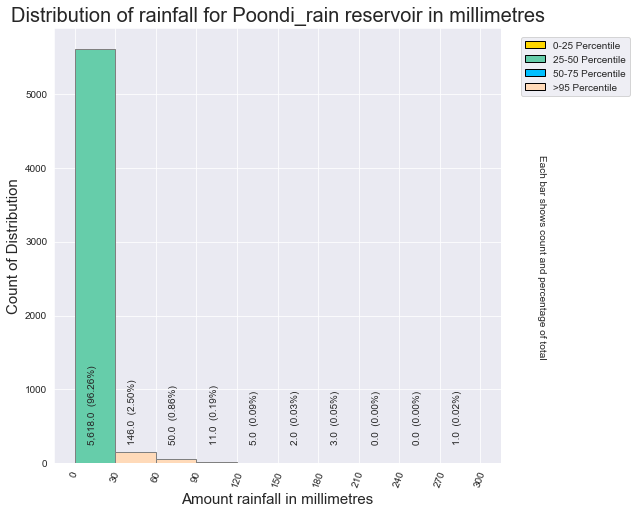

In [21]:
graph_percentile(df["Poondi_rain"])

In [21]:
df["time"] = range(len(df))

In [22]:
desired_lags = [1, 2, 3, 4, 8, 9, 10, 11, 12, 13]
reserv_with_lags = multi_lag_appender(df, "Chembarambakkam_water_level", desired_lags)
reserv_with_lags.head(14)

,Poondi_water_level,Poondi_rain,Cholavaram_water_level,Cholavaram_rain,Redhills_water_level,Redhills_rain,Chembarambakkam_water_level,Chembarambakkam_rain,time,Chembarambakkam_water_level_1,Chembarambakkam_water_level_2,Chembarambakkam_water_level_3,Chembarambakkam_water_level_4,Chembarambakkam_water_level_8,Chembarambakkam_water_level_9,Chembarambakkam_water_level_10,Chembarambakkam_water_level_11,Chembarambakkam_water_level_12,Chembarambakkam_water_level_13
Date,,,,,,,,,,,,,,,,,,,
2004-01-01,3.9,0.0,0.0,0.0,268.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-02,3.9,0.0,0.0,0.0,268.0,0.0,0.0,0.0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-03,3.9,0.0,0.0,0.0,267.0,0.0,0.0,0.0,2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-04,3.9,0.0,0.0,0.0,267.0,0.0,0.0,0.0,3,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-05,3.8,0.0,0.0,0.0,267.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-06,3.8,0.0,0.0,0.0,266.0,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-07,3.8,0.0,0.0,0.0,266.0,0.0,0.0,0.0,6,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-08,3.7,0.0,0.0,0.0,265.0,0.0,0.0,0.0,7,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-09,3.7,0.0,0.0,0.0,264.0,0.0,0.0,0.0,8,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


## Lags

In [23]:
def multi_lag_appender(df, column, lags, inplace = False):
    '''Appends the appropriate lag from the list of given lags to the give dataframe'''
    # copying datafame unless inplace = True
    df = df if inplace else df.copy()
    for lag in lags:
        df[f"{column}_{lag}"] = df[column].shift(lag)
    
    return None if inplace else df



## Model Preparation

In [40]:
reserv_with_lags.dropna(inplace= True)

In [41]:
X = reserv_with_lags.drop(columns=cols[1:])
y = reserv_with_lags["Chembarambakkam_water_level"]

# must NOT shuffle for time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .26, shuffle = False)

### Baseline

In [42]:
dumb = DummyRegressor(strategy='mean')

In [43]:
y_train.mean()

1430.850812253423

In [44]:
dumb.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [45]:
dumb.score(X_train, y_train)

0.0

In [46]:
dumb.score(X_test, y_test)

-0.33521409583375195

### Linear Regression

In [47]:
# instantiate
lr = LinearRegression()

# fit (original model fitted)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
lr.score(X_train, y_train)

0.9917212930931044

In [49]:
lr.score(X_test, y_test)

0.9954689001551672

In [50]:
X = reserv_with_lags.drop(columns=cols[1:])

X = sm.add_constant(X) # MUST add constant for statsmodels

y = reserv_with_lags["Chembarambakkam_water_level"]

# must NOT shuffle for time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = False)

In [51]:
# instantiate
ols = sm.OLS(y_train, X_train) # notice y goes first!

# fit
fitted_ols = ols.fit() # returned model is fitted, not the original!

In [52]:
fitted_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Chembarambakkam_water_level   R-squared:                       0.992
Model:                                     OLS   Adj. R-squared:                  0.992
Method:                          Least Squares   F-statistic:                 5.185e+04
Date:                         Thu, 03 Sep 2020   Prob (F-statistic):               0.00
Time:                                 00:15:46   Log-Likelihood:                -27281.
No. Observations:                         4658   AIC:                         5.459e+04
Df Residuals:                             4646   BIC:                         5.466e+04
Df Model:                                   11                                         
Covariance Type:                     nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              7.0227      3.036      2.313      0.021       1.070      12.975
time                              -0.0003      0.001     -0.304      0.762      -0.002       0.002
Chembarambakkam_water_level_1      0.7015      0.015     47.976      0.000       0.673       0.730
Chembarambakkam_water_level_2      0.2393      0.018     13.379      0.000       0.204       0.274
Chembarambakkam_water_level_3      0.0091      0.018      0.503      0.615      -0.026       0.044
Chembarambakkam_water_level_4      0.0896      0.016      5.546      0.000       0.058       0.121
Chembarambakkam_water_level_8      0.0082      0.016      0.504      0.614      -0.024       0.040
Chembarambakkam_water_level_9     -0.0009      0.018     -0.048      0.962      -0.036       0.035
Chembarambakkam_water_level_10    -0.0028      0.018     -0.152      0.879      -0.039       0.033
Chembarambakkam_water_level_11    -0.0092      0.018     -0.506      0.613      -0.045       0.026
Chembarambakkam_water_level_12    -0.0058      0.018     -0.325      0.746      -0.041       0.029
Chembarambakkam_water_level_13    -0.0331      0.015     -2.255      0.024      -0.062      -0.004
==============================================================================
Omnibus:                     6645.340   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         37934638.922
Skew:                           7.282   Prob(JB):                         0.00
Kurtosis:                     444.863   Cond. No.                     1.46e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
y_train_preds = fitted_ols.predict(X_train)
r2_score(y_train, y_train_preds)

0.9919203727152522

In [54]:
y_test_preds = fitted_ols.predict(X_test)
r2_score(y_test, y_test_preds)

0.9907998834085031

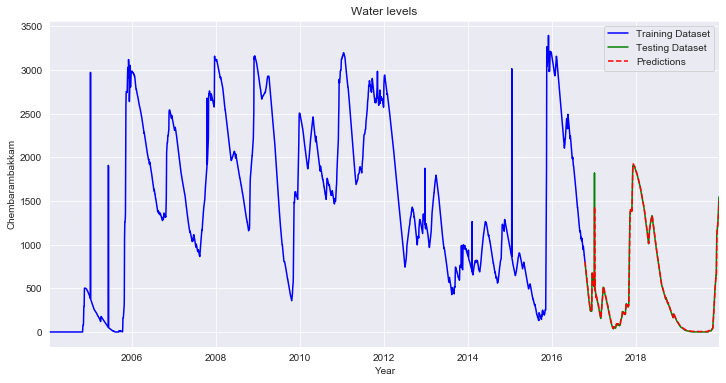

In [55]:
# Get forecasts for testing set
preds = fitted_ols.predict(X_test)

plt.figure(figsize=(12,6))
plt.title("Water levels")

# Plot time series predictions against actual values for ENTIRE dataset
y_train.plot(style="b")
y_test.plot(style="g")
preds.plot(style="r--") # red with dash
plt.xlabel("Year")
plt.ylabel("Chembarambakkam")
plt.legend(labels = ["Training Dataset", "Testing Dataset", "Predictions"]);

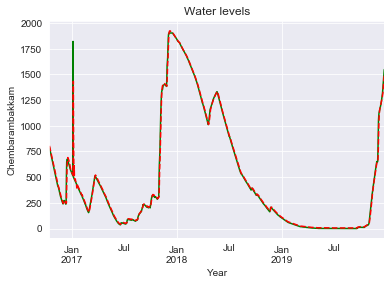

In [56]:
y_test.plot(style='g') 
preds.plot(style='r--')
plt.xlabel("Year")
plt.ylabel("Chembarambakkam")
plt.title("Water levels");

## Conclusions and Recommendations

## References